<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/notebooks/03-CNN-Image-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import copy
import warnings
from collections import defaultdict, deque
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla T4


# Load CIFAR10 data

In [3]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load train and validation set
dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [40000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# load test set
test_set = datasets.CIFAR10('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Number of training images: 40000
Number of validation images: 10000
Number of testing images: 10000
Size of each image: torch.Size([3, 32, 32])


## Show some images

In [0]:
def imshow(img, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

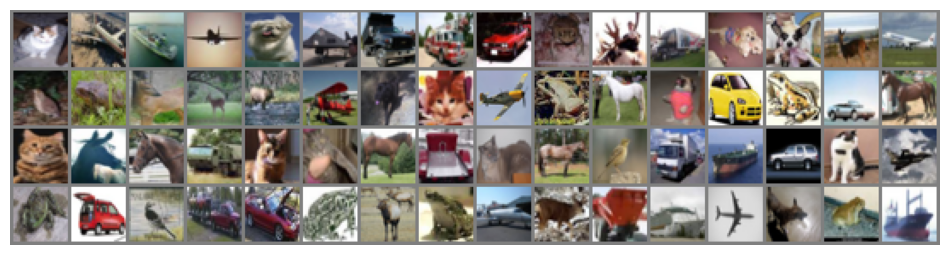

In [6]:
# get some random training images
data_iter = iter(data_loader['train'])
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(BATCH_SIZE/4))
imshow(grid, ax=ax)

In [7]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)
categories

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

# Convoluational Neural Network

In [0]:
class CNN(nn.Module):
    def __init__(self, output_size=output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# test network
cnn(torch.rand(1, 3, 32, 32))

tensor([[-0.0075,  0.0076, -0.0468,  0.0479, -0.1192, -0.0836, -0.1102, -0.0753,
          0.1412, -0.0718]], grad_fn=<AddmmBackward>)

## Train the network

In [0]:
def train(model, data_loader, epochs=5, lr=1e-3, momentum=0.9):
    model = model.to(device)
    # define training function
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = defaultdict(lambda: deque(maxlen=epochs))
    accuracy_history = defaultdict(lambda: deque(maxlen=epochs))

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 60)    

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # make predictions
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs.data, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total += labels.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_history[phase].append(epoch_loss)
            accuracy_history[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print('-' * 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.3f} %'.format(100 * best_acc))
    print('=' * 60, '\n')
    # load best weights
    model.load_state_dict(best_weights)
    return loss_history, accuracy_history

In [12]:
loss_history, accuracy_history = train(cnn, data_loader, epochs=10)

Epoch 1/10
------------------------------------------------------------
train Loss: 1.9253 Acc: 0.2933
val Loss: 1.6105 Acc: 0.4027
Epoch 2/10
------------------------------------------------------------
train Loss: 1.4673 Acc: 0.4637
val Loss: 1.3566 Acc: 0.5032
Epoch 3/10
------------------------------------------------------------
train Loss: 1.3144 Acc: 0.5272
val Loss: 1.3133 Acc: 0.5240
Epoch 4/10
------------------------------------------------------------
train Loss: 1.2046 Acc: 0.5700
val Loss: 1.2208 Acc: 0.5618
Epoch 5/10
------------------------------------------------------------
train Loss: 1.1265 Acc: 0.5990
val Loss: 1.1689 Acc: 0.5785
Epoch 6/10
------------------------------------------------------------
train Loss: 1.0575 Acc: 0.6270
val Loss: 1.1349 Acc: 0.5991
Epoch 7/10
------------------------------------------------------------
train Loss: 1.0078 Acc: 0.6438
val Loss: 1.1992 Acc: 0.5757
Epoch 8/10
------------------------------------------------------------
trai

## Visualize training performance

In [0]:
def plot_learning_curve(loss_history, accuracy_history, figsize=(12, 4)):

    x_values = range(1, len(loss_history['train'])+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharex=True)
    lines = dict(train='--', val='-')

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax1.plot(x_values, loss_history[phase], lines[phase],  label=f"{label}")

    plt.sca(ax1)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Loss")

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax2.plot(x_values, accuracy_history[phase], lines[phase], label=f"{label}")

    plt.sca(ax2)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Accuracy")
    _ = plt.suptitle(f"Training Performance\n")
    _ = plt.subplots_adjust(top=0.9)
    plt.show()

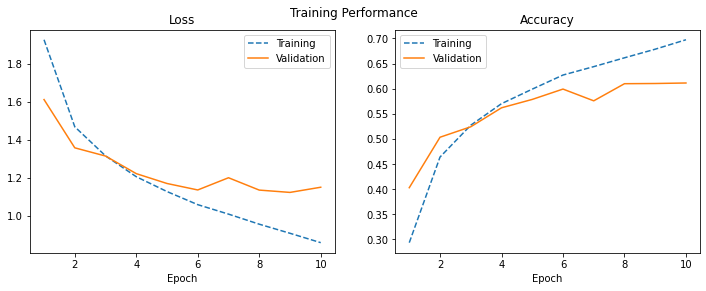

In [14]:
plot_learning_curve(loss_history, accuracy_history)

## Evaluate model

In [15]:
# convert dataset ids to classes
idx_to_class = {v:k for k,v in categories.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def plot_confusion_matrix(y_true, y_pred, labels, normalize=None, 
                          title='Confusion matrix', cmap=plt.cm.Blues, ax=None):
    """
    Function to plot confusion matrix.
    Adapted from: https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/metrics/_plot/confusion_matrix.py#L119
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp = disp.plot(cmap=cmap, ax=ax)
    _ = disp.ax_.set_title(title)
    disp.ax_.grid(False)
    return disp.ax_


def predict(model, test_loader):
    """Function to predict test data"""
    correct, total = 0, 0
    targets = []
    predictions = []

    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted ==labels).sum().item()
            # append labels
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())

    score = correct / total
    targets = [idx_to_class[i] for i in targets]
    predictions = [idx_to_class[i] for i in predictions]
    return score, targets, predictions

In [0]:
# make test predictions
score, y_true, y_pred = predict(cnn, test_loader)

In [18]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 61.09 %


In [19]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.64      0.68      0.66      1000
  automobile       0.69      0.78      0.73      1000
        bird       0.49      0.52      0.50      1000
         cat       0.43      0.32      0.36      1000
        deer       0.54      0.56      0.55      1000
         dog       0.55      0.54      0.54      1000
        frog       0.73      0.63      0.67      1000
       horse       0.63      0.72      0.67      1000
        ship       0.80      0.65      0.72      1000
       truck       0.62      0.71      0.66      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000




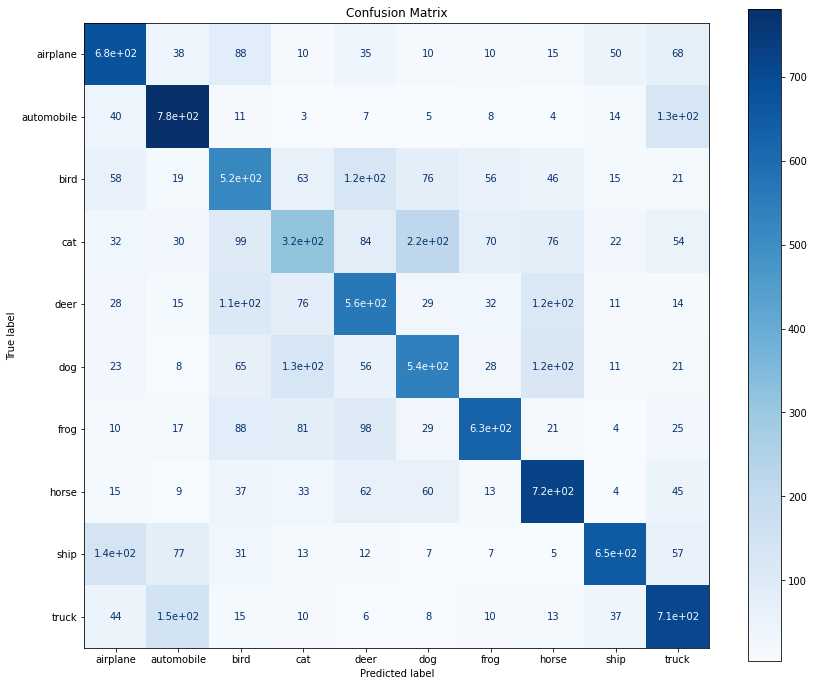

In [20]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': cnn.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_cnn.pth')

In [22]:
!ls -lh cifar10_cnn.pth

-rw-r--r-- 1 root root 244K Jun  7 13:47 cifar10_cnn.pth


# Using Pretrained models

In [24]:
# Use alexnet model without pretrained weights
alexnet = torchvision.models.alexnet(num_classes=output_size, pretrained=False)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# reload and resize images
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load train and validation set
dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [40000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# load test set
test_set = datasets.CIFAR10('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Files already downloaded and verified
Files already downloaded and verified
Number of training images: 40000
Number of validation images: 10000
Number of testing images: 10000
Size of each image: torch.Size([3, 227, 227])


In [0]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)

## Train model

In [27]:
loss_history, accuracy_history = train(alexnet, data_loader, epochs=10)

Epoch 1/10
------------------------------------------------------------
train Loss: 3.3016 Acc: 0.1195
val Loss: 2.2284 Acc: 0.1912
Epoch 2/10
------------------------------------------------------------
train Loss: 2.0315 Acc: 0.2481
val Loss: 1.9044 Acc: 0.2797
Epoch 3/10
------------------------------------------------------------
train Loss: 1.7734 Acc: 0.3413
val Loss: 1.6698 Acc: 0.3818
Epoch 4/10
------------------------------------------------------------
train Loss: 1.5818 Acc: 0.4214
val Loss: 1.5114 Acc: 0.4472
Epoch 5/10
------------------------------------------------------------
train Loss: 1.4453 Acc: 0.4749
val Loss: 1.3878 Acc: 0.4986
Epoch 6/10
------------------------------------------------------------
train Loss: 1.3206 Acc: 0.5224
val Loss: 1.2643 Acc: 0.5463
Epoch 7/10
------------------------------------------------------------
train Loss: 1.2107 Acc: 0.5658
val Loss: 1.1636 Acc: 0.5903
Epoch 8/10
------------------------------------------------------------
trai

## Visualize training performance

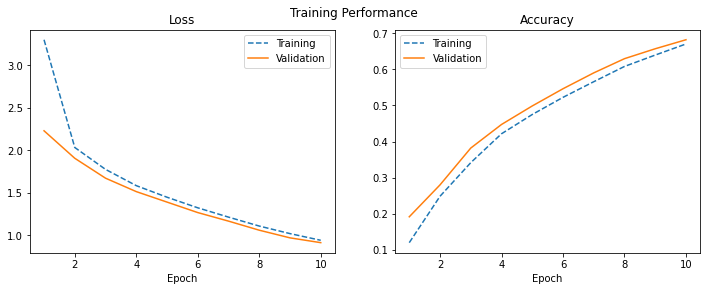

In [28]:
plot_learning_curve(loss_history, accuracy_history)

## Evaluate model

In [0]:
# make test predictions
score, y_true, y_pred = predict(alexnet, test_loader)

In [38]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 68.86 %


In [39]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.79      0.64      0.71      1000
  automobile       0.79      0.86      0.83      1000
        bird       0.68      0.47      0.55      1000
         cat       0.47      0.52      0.50      1000
        deer       0.66      0.58      0.62      1000
         dog       0.54      0.69      0.60      1000
        frog       0.81      0.71      0.76      1000
       horse       0.67      0.79      0.73      1000
        ship       0.75      0.85      0.80      1000
       truck       0.81      0.77      0.79      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000




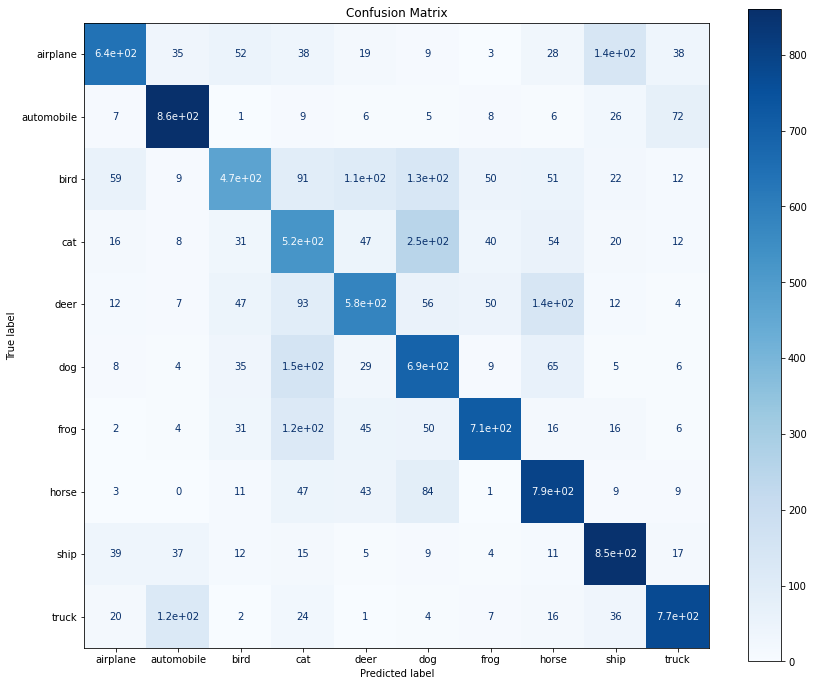

In [40]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': alexnet.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_alexnet.pth')

# Transfer learning using ResNet

In [0]:
# Load resnet with pretrained weights
resnet = torchvision.models.resnet50(pretrained=True)
# freeze training of trained parameters except batch normalization layers
for name, param in resnet.named_parameters():
    if ("bn" not in name):  # skip batch norm layers
        param.requires_grad = False

In [47]:
# view frozen layers
for name, param in resnet.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight True
bn1.bias True
layer1.0.conv1.weight False
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight False
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight False
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight False
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight False
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight False
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight False
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight False
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight False
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight False
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.con

In [0]:
# connect Fully connected layers for classifying the images
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, output_size)
)

In [49]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train model

In [0]:
loss_history, accuracy_history = train(resnet, data_loader, epochs=10)

Epoch 1/10
------------------------------------------------------------


## Visualize training performance

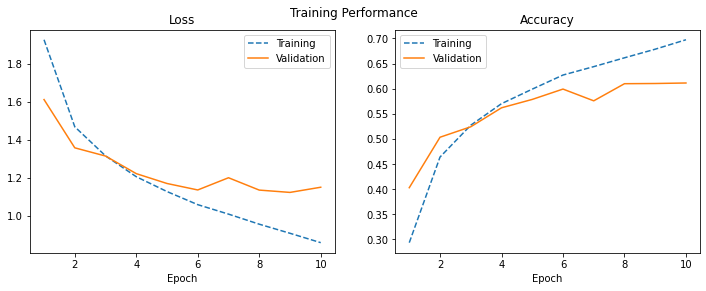

In [0]:
plot_learning_curve(loss_history, accuracy_history)

## Evaluate model

In [0]:
# make test predictions
score, y_true, y_pred = predict(resnet, test_loader)

In [0]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 61.09 %


In [0]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.64      0.68      0.66      1000
  automobile       0.69      0.78      0.73      1000
        bird       0.49      0.52      0.50      1000
         cat       0.43      0.32      0.36      1000
        deer       0.54      0.56      0.55      1000
         dog       0.55      0.54      0.54      1000
        frog       0.73      0.63      0.67      1000
       horse       0.63      0.72      0.67      1000
        ship       0.80      0.65      0.72      1000
       truck       0.62      0.71      0.66      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000




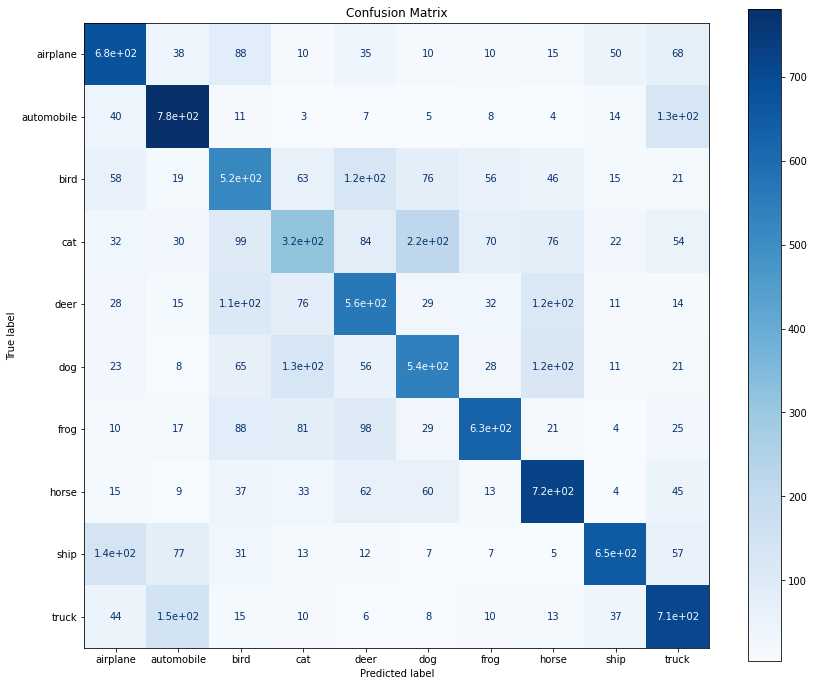

In [0]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': resnet.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_resnet.pth')

In [31]:
1e-2

0.01